## Photometry With MCMC

Having gotten the target files in the previous notebook, I'm going to now use the file `corecomposition/photometry.py` to fetch more photometry from either DES or PANSTARRS. Then, I'll run MCMC with a much better constraint on the temperature which will also give me a better constraint on the radius. 

First, I'll read in the gold, silver, and bronze samples. The gold and silver samples are both subsets of the bronze sample, so I'll do all of the analysis on the bronze table (since that will also analyze the stars in the gold and silver samples). 

In [9]:
### general
import numpy as np
import pickle
import matplotlib.pyplot as plt
plt.style.use('stefan.mplstyle')

### astropy
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, join, vstack, unique

### project-specific
import sys
sys.path.append('../')
sys.path.append('../../')
import corecomposition as cc
import WD_models

gold = Table.read('../data/processed/gold.csv')
silver = Table.read('../data/processed/silver.csv')
bronze = Table.read('../data/processed/bronze.csv')

In [10]:
target_ids = [3249027001465705088, 4750614226039509888, 4248619071266347648, 3970162318385391488, 3090038517737811712]

In [11]:
elbadry = Table.read('../data/raw/elbadry.csv')

In [12]:
mask = np.isin(elbadry['wd_source_id'].data, target_ids)
targets = elbadry[mask].copy()

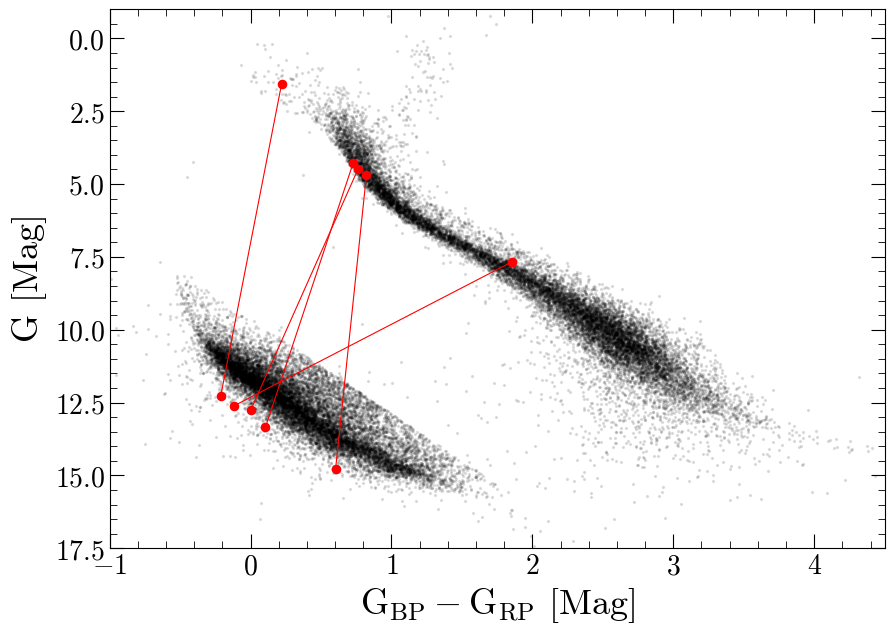

In [13]:
goodmask = np.all([elbadry['ms_parallax_over_error'] > 5], axis=0)
s_target = 35
color = 'red'

plt.figure(figsize=(10,7))
plt.scatter(elbadry[goodmask]['ms_phot_bp_mean_mag'] - elbadry[goodmask]['ms_phot_rp_mean_mag'],
            elbadry[goodmask]['ms_phot_g_mean_mag'] + 5 * np.log10(elbadry[goodmask]['ms_parallax'] / 100),
            s=2, c='k', alpha=0.1)
plt.scatter(elbadry[goodmask]['wd_phot_bp_mean_mag'] - elbadry[goodmask]['wd_phot_rp_mean_mag'],
            elbadry[goodmask]['wd_phot_g_mean_mag'] + 5 * np.log10(elbadry[goodmask]['ms_parallax'] / 100),
            s=2, c='k', alpha=0.1)
plt.scatter(elbadry[mask]['ms_phot_bp_mean_mag'] - elbadry[mask]['ms_phot_rp_mean_mag'],
            elbadry[mask]['ms_phot_g_mean_mag'] + 5 * np.log10(elbadry[mask]['ms_parallax'] / 100),
            c = color, s = s_target)
plt.scatter(elbadry[mask]['wd_phot_bp_mean_mag'] - elbadry[mask]['wd_phot_rp_mean_mag'],
            elbadry[mask]['wd_phot_g_mean_mag'] + 5 * np.log10(elbadry[mask]['ms_parallax'] / 100),
            c = color, s = s_target)

for i in range(len(elbadry[mask])):
    plt.plot([elbadry[mask]['wd_phot_bp_mean_mag'][i] - elbadry[mask]['wd_phot_rp_mean_mag'][i], 
                elbadry[mask]['ms_phot_bp_mean_mag'][i] - elbadry[mask]['ms_phot_rp_mean_mag'][i]], 
                [elbadry[mask]['wd_phot_g_mean_mag'][i] + 5 * np.log10(elbadry[mask]['ms_parallax'][i] / 100), 
                elbadry[mask]['ms_phot_g_mean_mag'][i] + 5 * np.log10(elbadry[mask]['ms_parallax'][i] / 100)], 
    c = color, ls='-', lw = 0.8)


plt.xlabel(r'$G_{BP} - G_{RP}$ [Mag]')
plt.ylabel(r'$G$ [Mag]')
plt.xlim(-1, 4.5)
plt.ylim(-1, 17.5)
plt.gca().invert_yaxis()
plt.savefig('../figures/UVES_fa24_CMD.pdf')

It seems like most of the ground-based photometry is going to be contaminated by brighter field stars. That means that we'll have to 

In [14]:
vincent_class = Table.read('https://cdsarc.cds.unistra.fr/viz-bin/nph-Cat/fits?J/A+A/682/A5/catalog.dat.gz')
targets = join(targets, vincent_class, keys_left='wd_source_id', keys_right='GaiaDR3', join_type='left')

In [15]:
ps_photo = cc.photometry.fetch_photometry(targets['wd_source_id'].data)
targets = join(targets, ps_photo, keys_left='wd_source_id', keys_right='source_id', join_type='outer')

In [16]:
# dustmap for dereddening
from dustmaps.edenhofer2023 import Edenhofer2023Query
bsq = Edenhofer2023Query()

Optimizing map for querying (this might take a couple of seconds)...


In [18]:
targets = cc.selection.get_bailerjones(targets)
targets = cc.selection.make_physical_photometry(targets)
targets = cc.selection.radius_from_cmd(targets)
targets = cc.selection.deredden_gaia(targets, bsq)

100%|██████████| 5/5 [00:00<00:00, 45.96it/s]


In [19]:
targets

wd_solution_id,ms_solution_id,wd_source_id,ms_source_id,wd_random_index,ms_random_index,wd_ref_epoch,ms_ref_epoch,wd_ra,ms_ra,wd_ra_error,ms_ra_error,wd_dec,ms_dec,wd_dec_error,ms_dec_error,wd_parallax,ms_parallax,wd_parallax_error,ms_parallax_error,wd_parallax_over_error,ms_parallax_over_error,wd_pm,ms_pm,wd_pmra,ms_pmra,wd_pmra_error,ms_pmra_error,wd_pmdec,ms_pmdec,wd_pmdec_error,ms_pmdec_error,wd_ra_dec_corr,ms_ra_dec_corr,wd_ra_parallax_corr,ms_ra_parallax_corr,wd_ra_pmra_corr,ms_ra_pmra_corr,wd_ra_pmdec_corr,ms_ra_pmdec_corr,wd_dec_parallax_corr,ms_dec_parallax_corr,wd_dec_pmra_corr,ms_dec_pmra_corr,wd_dec_pmdec_corr,ms_dec_pmdec_corr,wd_parallax_pmra_corr,ms_parallax_pmra_corr,wd_parallax_pmdec_corr,ms_parallax_pmdec_corr,wd_pmra_pmdec_corr,ms_pmra_pmdec_corr,wd_astrometric_n_obs_al,ms_astrometric_n_obs_al,wd_astrometric_n_obs_ac,ms_astrometric_n_obs_ac,wd_astrometric_n_good_obs_al,ms_astrometric_n_good_obs_al,wd_astrometric_n_bad_obs_al,ms_astrometric_n_bad_obs_al,wd_astrometric_gof_al,ms_astrometric_gof_al,wd_astrometric_chi2_al,ms_astrometric_chi2_al,wd_astrometric_excess_noise,ms_astrometric_excess_noise,wd_astrometric_excess_noise_sig,ms_astrometric_excess_noise_sig,wd_astrometric_params_solved,ms_astrometric_params_solved,wd_astrometric_primary_flag,ms_astrometric_primary_flag,wd_nu_eff_used_in_astrometry,ms_nu_eff_used_in_astrometry,wd_pseudocolour,ms_pseudocolour,wd_pseudocolour_error,ms_pseudocolour_error,wd_ra_pseudocolour_corr,ms_ra_pseudocolour_corr,wd_dec_pseudocolour_corr,ms_dec_pseudocolour_corr,wd_parallax_pseudocolour_corr,ms_parallax_pseudocolour_corr,wd_pmra_pseudocolour_corr,ms_pmra_pseudocolour_corr,wd_pmdec_pseudocolour_corr,ms_pmdec_pseudocolour_corr,wd_astrometric_matched_transits,ms_astrometric_matched_transits,wd_visibility_periods_used,ms_visibility_periods_used,wd_astrometric_sigma5d_max,ms_astrometric_sigma5d_max,wd_matched_transits,ms_matched_transits,wd_new_matched_transits,ms_new_matched_transits,wd_matched_transits_removed,ms_matched_transits_removed,wd_ipd_gof_harmonic_amplitude,ms_ipd_gof_harmonic_amplitude,wd_ipd_gof_harmonic_phase,ms_ipd_gof_harmonic_phase,wd_ipd_frac_multi_peak,ms_ipd_frac_multi_peak,wd_ipd_frac_odd_win,ms_ipd_frac_odd_win,wd_ruwe,ms_ruwe,wd_scan_direction_strength_k1,ms_scan_direction_strength_k1,wd_scan_direction_strength_k2,ms_scan_direction_strength_k2,wd_scan_direction_strength_k3,ms_scan_direction_strength_k3,wd_scan_direction_strength_k4,ms_scan_direction_strength_k4,wd_scan_direction_mean_k1,ms_scan_direction_mean_k1,wd_scan_direction_mean_k2,ms_scan_direction_mean_k2,wd_scan_direction_mean_k3,ms_scan_direction_mean_k3,wd_scan_direction_mean_k4,ms_scan_direction_mean_k4,wd_duplicated_source,ms_duplicated_source,wd_phot_g_n_obs,ms_phot_g_n_obs,wd_phot_g_mean_flux,ms_phot_g_mean_flux,wd_phot_g_mean_flux_error,ms_phot_g_mean_flux_error,wd_phot_g_mean_flux_over_error,ms_phot_g_mean_flux_over_error,wd_phot_g_mean_mag,ms_phot_g_mean_mag,wd_phot_bp_n_obs,ms_phot_bp_n_obs,wd_phot_bp_mean_flux,ms_phot_bp_mean_flux,wd_phot_bp_mean_flux_error,ms_phot_bp_mean_flux_error,wd_phot_bp_mean_flux_over_error,ms_phot_bp_mean_flux_over_error,wd_phot_bp_mean_mag,ms_phot_bp_mean_mag,wd_phot_rp_n_obs,ms_phot_rp_n_obs,wd_phot_rp_mean_flux,ms_phot_rp_mean_flux,wd_phot_rp_mean_flux_error,ms_phot_rp_mean_flux_error,wd_phot_rp_mean_flux_over_error,ms_phot_rp_mean_flux_over_error,wd_phot_rp_mean_mag,ms_phot_rp_mean_mag,wd_phot_bp_n_contaminated_transits,ms_phot_bp_n_contaminated_transits,wd_phot_bp_n_blended_transits,ms_phot_bp_n_blended_transits,wd_phot_rp_n_contaminated_transits,ms_phot_rp_n_contaminated_transits,wd_phot_rp_n_blended_transits,ms_phot_rp_n_blended_transits,wd_phot_proc_mode,ms_phot_proc_mode,wd_phot_bp_rp_excess_factor,ms_phot_bp_rp_excess_factor,wd_bp_rp,ms_bp_rp,wd_bp_g,ms_bp_g,wd_g_rp,ms_g_rp,wd_dr2_radial_velocity,ms_dr2_radial_velocity,wd_dr2_radial_velocity_error,ms_dr2_radial_velocity_error,wd_dr2_rv_nb_transits,ms_dr2_rv_nb_transits,wd_dr2_rv_template_teff,ms_dr2

In [20]:
#with open('../data/cleaned/radius_chains_warwick_gaia.pkl', 'rb') as f:
#    gaia_chains = pickle.load(f)

#with open('../data/cleaned/radius_chains_ONe_Hdef.pkl', 'rb') as f:
#    one_hdef_chains = pickle.load(f)

#with open('../data/cleaned/radius_chains_ONe_Hrich.pkl', 'rb') as f:
#    one_hrich_chains = pickle.load(f)

In [21]:
import sys
sys.path.append('../')
from corecomposition import interpolator
import corner
import pickle
from tqdm import tqdm

gaia_chains = {}
base_wavl, model_spec, model_spec_low_logg, table = cc.interpolator.utils.build_warwick_da()
build_spec = lambda best_est, distance : 4*np.pi*model_spec((best_est[0], 9)) * ((best_est[1] * 6.957e8) / (distance * 3.086775e16))**2

for j in tqdm(range(len(targets['wd_source_id']))):
    source_id = targets['wd_source_id'][j]
    distance = targets['r_med_geo'][j]
    # if the target has an XP spectrum, use only Gaia photometry with a teff constraint
    if not isinstance(targets['GaiaDR3'][j], np.ma.core.MaskedConstant):
        bands = ['Gaia_G', 'Gaia_BP', 'Gaia_RP']
        photomet = np.array([targets['gmag_dereddened'], targets['bpmag_dereddened'], targets['rpmag_dereddened']]).T[j]
        e_photomet = np.array([targets['wd_e_gmag'], targets['wd_e_bpmag'], targets['wd_e_rpmag']]).T[j]
        initial_guess = np.array([targets['Teff'], targets['cmd_radius']]).T[j]
        teff_constraint = np.array([targets['Teff'], targets['e_Teff']]).T[j]
    else:
        bands = ['Gaia_G', 'Gaia_BP', 'Gaia_RP']#, 'PS1_g', 'PS1_r', 'PS1_i', 'PS1_z', 'PS1_y']
        photomet = np.array([targets['gmag_dereddened'], targets['bpmag_dereddened'], targets['rpmag_dereddened']]).T[j]#, 
                            # targets['PS1_g'], targets['PS1_r'], targets['PS1_i'], targets['PS1_z'], targets['PS1_y']]).T[j]
        e_photomet = np.array([targets['wd_e_gmag'], targets['wd_e_bpmag'], targets['wd_e_rpmag']]).T[j]#,
                             #targets['e_PS1_g'], targets['e_PS1_r'], targets['e_PS1_i'], targets['e_PS1_z'], targets['e_PS1_y']]).T[j]
        teff_constraint = np.array([None, None])
        initial_guess = np.array([10000, targets['cmd_radius'][j]])

    print(photomet, e_photomet, distance, initial_guess, teff_constraint)

    gaia_model = interpolator.WarwickDAInterpolator(bands)
    # run the MCMC fit using one of the interpolators
    gaia_engine = interpolator.MCMCEngine(gaia_model)
    gaia_flat_chain = gaia_engine.run_mcmc(photomet, e_photomet, distance, initial_guess, teff_constraint)
    gaia_chains[source_id] = gaia_flat_chain

with open('../data/cleaned/fa24_UVES_radius_chains_warwick.pkl', 'wb') as f:
    pickle.dump(gaia_chains, f)

  0%|          | 0/5 [00:00<?, ?it/s]

[19.46771948 19.61322792 19.00998532] [0.00287245 0.04970009 0.03528614] 86.56998 [6.50600000e+03 7.46528157e-03] [6506  244]
6506 244


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [51.18614076 50.95002842]


Auto-Correlation Time = 51.18614075904223, additional steps = 161


 20%|██        | 1/5 [00:33<02:15, 33.98s/it]

[18.22249041 18.20595534 18.41972453] [0.00143986 0.01401281 0.02423898] 153.67923 [1.64080000e+04 7.20902572e-03] [16408   889]
16408 889


 40%|████      | 2/5 [01:07<01:41, 33.72s/it]

Auto-Correlation Time = 46.50782603458078, additional steps = -82
[19.16857234 19.2243096  19.22278516] [0.00353855 0.04608748 0.07612711] 190.55106 [1.00000000e+04 7.84999605e-03] [None None]
None None


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [243.4962897  239.61621971]


Auto-Correlation Time = 243.49628969902852, additional steps = 10161


 60%|██████    | 3/5 [04:39<03:50, 115.30s/it]

[19.12029722 19.17510911 19.06953206] [0.00167555 0.025341   0.03793036] 142.311 [1.01780000e+04 7.00262324e-03] [10178   506]
10178 506


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [108.28089331 107.89916286]


Auto-Correlation Time = 108.28089330732017, additional steps = 3130


 80%|████████  | 4/5 [06:13<01:46, 106.74s/it]

[18.58383496 18.57350794 18.68873358] [0.00162153 0.01514691 0.01756934] 156.11517 [1.3967000e+04 7.1775459e-03] [13967   832]
13967 832


In [12]:
def build_radius_table(chain):
    source_ids = list(chain.keys())
    radius_med = []
    radius_low = []
    radius_high = []

    teff_med = []
    teff_low = []
    teff_high = []

    for wdid in source_ids:
        mcmc = np.percentile(chain[wdid][:,1],[16,50,84])
        unc = np.diff(mcmc)
        radius_med.append(mcmc[1])
        radius_low.append(unc[0])
        radius_high.append(unc[1])

        mcmc = np.percentile(chain[wdid][:,0],[16,50,84])
        unc = np.diff(mcmc)
        teff_med.append(mcmc[1])
        teff_low.append(unc[0])
        teff_high.append(unc[1])

    radius_table = Table()
    radius_table['wd_source_id'] = source_ids
    radius_table['radius_med'] = radius_med
    radius_table['radius_unc_low'] = radius_low
    radius_table['radius_unc_high'] = radius_high
    radius_table['e_radius'] = 0.5 * np.abs(radius_table['radius_unc_high'] + radius_table['radius_unc_low'])
    radius_table['radius_pct_error'] = radius_table['e_radius'] / radius_table['radius_med'] * 100
    
    radius_table['teff_med'] = teff_med
    radius_table['teff_unc_low'] = teff_low
    radius_table['teff_unc_high'] = teff_high
    radius_table['e_teff'] = 0.5 * np.abs(radius_table['teff_unc_high'] + radius_table['teff_unc_low'])
    radius_table['teff_pct_error'] = radius_table['e_teff'] / radius_table['teff_med'] * 100
    return radius_table

radius_table = build_radius_table(gaia_chains)
radius_table.write('../data/cleaned/fa24_UVES_radius_table_warwick.csv', overwrite=True)

In [13]:
targets = join(targets, radius_table, keys='wd_source_id')


wd_source_id,wd_phot_g_mean_mag,wd_ra,wd_dec,cmd_radius,SpType,source,radius_med,radius_unc_high,radius_unc_low,radius_pct_error,teff_med,teff_unc_high,teff_unc_low,teff_pct_error
int64,float64,float64,float64,float64,bytes3,str3,float64,float64,float64,float64,float64,float64,float64,float64
3090038517737811712,19.467735290527344,125.10155969827336,1.3826973946792267,0.007465281573923653,DA,ps1,0.007649465965445825,0.0003445381716081757,0.00036611950229746126,4.6451456684415655,6482.271218297727,172.38454926589566,171.0475822002145,2.6490108165845685
3249027001465705088,18.224544525146484,53.713824909148926,-3.4247499092447784,0.007209025716118518,DA,ps1,0.007425606037324076,0.00019735149614181352,0.00019398957763726125,2.6350783478953606,16917.19785453525,558.9342739464773,566.8572156352893,3.327358050848707
3970162318385391488,19.168611526489258,169.09460279090723,15.82320002661066,0.007849996046745349,--,ps1,0.007461719962325145,0.001057256107758607,0.0008232656119507194,12.601127683726002,12414.640262985087,1830.7250271452613,1331.4038321610333,12.735483237216105
4248619071266347648,19.120485305786133,301.35106967868836,5.137256051068365,0.007002623240401826,DA,ps1,0.007023713679907039,0.00034512853051493503,0.0003343134245730626,4.83677144351498,10482.442750712864,370.48292569195837,358.1381906003662,3.475435705302442
4750614226039509888,18.58385467529297,46.49363872797763,-47.772247209794116,0.007177545902775804,DA,des,0.00699213620868666,9.674303378621064e-05,0.0001344497065376704,1.6532339575755075,14796.512286591136,580.8691762817998,459.6944351764141,3.5162462318947667


In [18]:
targets['laplata_hrich_mass'] =  interpolator.LaPlataBase(['Gaia_G'], layer='Hrich').radiustomass(targets['radius_med'], targets['teff_med'])
targets['laplata_hdef_mass'] =  interpolator.LaPlataBase(['Gaia_G'], layer='Hdef').radiustomass(targets['radius_med'], targets['teff_med'])

In [19]:
targets[['wd_source_id', 'wd_phot_g_mean_mag', 'wd_ra', 'wd_dec', 'cmd_radius', 'SpType', 'source', 'laplata_hrich_mass', 'laplata_hdef_mass', 'radius_med', 'radius_unc_high', 'radius_unc_low', 'radius_pct_error', 'teff_med', 'teff_unc_high', 'teff_unc_low', 'teff_pct_error']]

wd_source_id,wd_phot_g_mean_mag,wd_ra,wd_dec,cmd_radius,SpType,source,laplata_hrich_mass,laplata_hdef_mass,radius_med,radius_unc_high,radius_unc_low,radius_pct_error,teff_med,teff_unc_high,teff_unc_low,teff_pct_error
int64,float64,float64,float64,float64,bytes3,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3090038517737811712,19.467735290527344,125.10155969827336,1.3826973946792267,0.007465281573923653,DA,ps1,0.985785384695073,0.9631116492556041,0.007649465965445825,0.0003445381716081757,0.00036611950229746126,4.6451456684415655,6482.271218297727,172.38454926589566,171.0475822002145,2.6490108165845685
3249027001465705088,18.224544525146484,53.713824909148926,-3.4247499092447784,0.007209025716118518,DA,ps1,1.0191339762411555,0.9958354545872384,0.007425606037324076,0.00019735149614181352,0.00019398957763726125,2.6350783478953606,16917.19785453525,558.9342739464773,566.8572156352893,3.327358050848707
3970162318385391488,19.168611526489258,169.09460279090723,15.82320002661066,0.007849996046745349,--,ps1,1.0027199295385252,0.9878493460931496,0.007461719962325145,0.001057256107758607,0.0008232656119507194,12.601127683726002,12414.640262985087,1830.7250271452613,1331.4038321610333,12.735483237216105
4248619071266347648,19.120485305786133,301.35106967868836,5.137256051068365,0.007002623240401826,DA,ps1,1.0339649490880647,1.017349183165654,0.007023713679907039,0.00034512853051493503,0.0003343134245730626,4.83677144351498,10482.442750712864,370.48292569195837,358.1381906003662,3.475435705302442
4750614226039509888,18.58385467529297,46.49363872797763,-47.772247209794116,0.007177545902775804,DA,des,1.0660428608022774,1.025457261832198,0.00699213620868666,9.674303378621064e-05,0.0001344497065376704,1.6532339575755075,14796.512286591136,580.8691762817998,459.6944351764141,3.5162462318947667


In [20]:
targets['radius_med'] * 109.075

0.8343655001810034
0.8099479785211235
0.8138871048906152
0.7661115696358602
0.7626672569624975
